In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from IPython.display import IFrame
import pandas as pd

ox.config(log_console=True, use_cache=True)

## get started; plot SF map

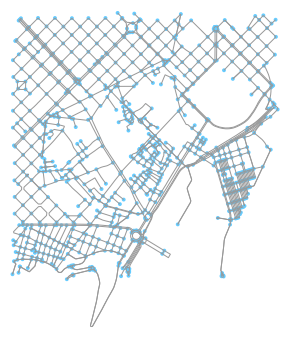

<Figure size 432x288 with 0 Axes>

In [2]:
# 1. Place you are interested
place = "Barcelona, Spain"
# 2. Transportation mode
mode = "drive"
# 3. Create network graph from place and mode
G = ox.graph_from_address(place, distance=1500, simplify=True, network_type=mode)
# 4. Plot the network graph
fig, ax = ox.plot_graph(G);
plt.tight_layout()
plt.show()

In [3]:
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'stockholm.html'
graph_map.save(filepath)
IFrame(filepath, width=900, height=500)


## PLOT SF MAP FOR A GIVEN NODE

In [13]:
df_edges = pd.read_pickle('./tables/edges.pkl')
df_nodes = pd.read_pickle('./tables/nodes.pkl')

In [3]:
min_lat = min(df_nodes.Lat)
min_lon = min(df_nodes.Lon)

In [4]:
dist = 1000
transport_mode = "drive"
coordinates = ox.graph_from_point((min_lat, min_lon), distance=dist, network_type=transport_mode )

In [5]:
# Plot the graph with Folium
graph_map = ox.plot_graph_folium(coordinates, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'coordinates.html'
graph_map.save(filepath)
IFrame(filepath, width=900, height=500)

## COMPUTE TRAVEL TIMES 

In [8]:
# CREATE SF GRAPH AROUND POINT OF INTEREST

In [31]:
mean_lat = sum(df_nodes.Lat)/len(df_nodes)
mean_lon = sum(df_nodes.Lon)/len(df_nodes)

dist = 1500
transport_mode = "drive"
SF = ox.graph_from_point((mean_lat, mean_lon), distance=dist, \
                         distance_type='bbox', network_type=transport_mode )

# Plot the graph with Folium
graph_map = ox.plot_graph_folium(SF, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'SF.html'
graph_map.save(filepath)
IFrame(filepath, width=800, height=400)

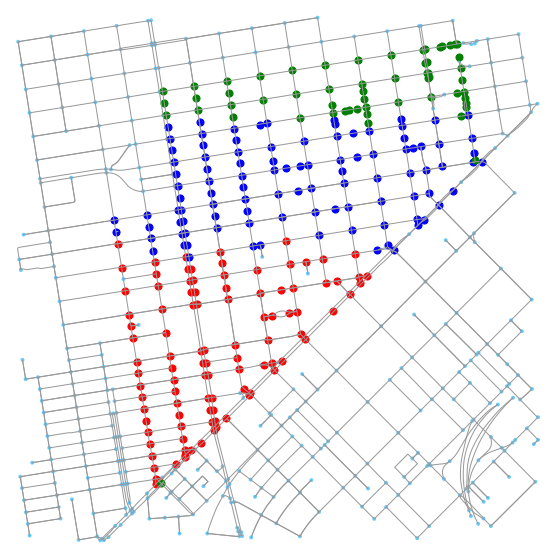

In [36]:
mean_lat = sum(df_nodes.Lat)/len(df_nodes) - 0.002
mean_lon = sum(df_nodes.Lon)/len(df_nodes)

dist = 1150
transport_mode = "drive"
SF = ox.graph_from_point((mean_lat, mean_lon), distance=dist, distance_type='bbox', network_type=transport_mode )

fig, ax = ox.plot_graph(SF, show=False, close=False, fig_height=10)

for i in range(len(df_nodes)):
    if int(df_nodes.iloc[i].ID) <= 100:
        ax.scatter(df_nodes.iloc[i].Lon,df_nodes.iloc[i].Lat, c='red', s=50)
    elif 100 < int(df_nodes.iloc[i].ID) <= 200:
        ax.scatter(df_nodes.iloc[i].Lon,df_nodes.iloc[i].Lat, c='blue', s=50)
    else:
        ax.scatter(df_nodes.iloc[i].Lon,df_nodes.iloc[i].Lat, c='green', s=50)
    



plt.show()

In [15]:
max_d = 0
node = 0
distances = []
for i in range(len(df_nodes)):
    _, d = ox.get_nearest_node(SF, point=(df_nodes.iloc[i].Lat, df_nodes.iloc[i].Lon), return_dist=True)
    distances.append(d)
    if max_d < d:
        max_d = d
        node = i
print('Maximum distance {} for node {}'.format(max_d, node))

Maximum distance 104.08182484575039 for node 68


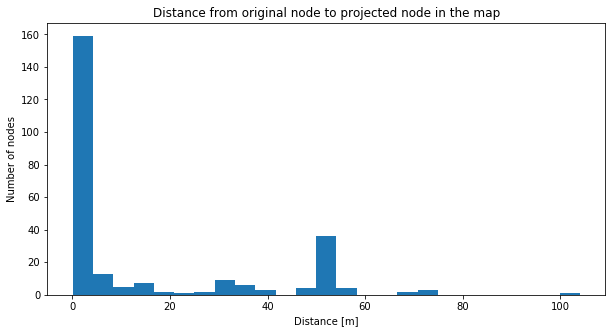

In [16]:
plt.figure(figsize=(10,5))
plt.hist(distances, bins=25)
plt.ylabel('Number of nodes')
plt.xlabel('Distance [m]')
plt.title('Distance from original node to projected node in the map')
plt.show()

In [12]:
#Project a graph from lat-long to the UTM zone appropriate for its geographic location.
#SF = ox.project_graph(SF)

In [13]:
travel_speed = 1

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in SF.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [14]:
# closest node to out point of interest
starting_node = ox.get_nearest_node(coordinates, point=(df_nodes.iloc[1].Lat, df_nodes.iloc[1].Lon))
end_point = ox.get_nearest_node(coordinates, point=(df_nodes.iloc[5].Lat, df_nodes.iloc[5].Lon))

# compute shortest way
nx.shortest_path_length(SF, starting_node, end_point, weight='time')

21.09126

In [15]:
shortest_path = nx.shortest_path(SF, starting_node, end_point, weight='time')

In [16]:
print(starting_node)
print(end_point)

1723739367
65329076


In [17]:
print(shortest_path)

[1723739367, 6386806910, 1723738852, 6454317981, 1723739120, 65350736, 65329076]


In [18]:
t = 0
time_vect = [0]
for i in range(len(shortest_path)-1):
    delta_t = nx.shortest_path_length(SF, shortest_path[i], shortest_path[i+1], weight='time')
    print('time {:.2f}'.format(delta_t))
    t += delta_t
    time_vect.append(t)
    print('total time {:.2f}'.format(t))

time 0.98
total time 0.98
time 0.51
total time 1.50
time 3.32
total time 4.82
time 6.40
total time 11.22
time 1.19
total time 12.40
time 8.69
total time 21.09


In [19]:
time_vect

[0,
 0.9823799999999998,
 1.4959199999999997,
 4.8195,
 11.21514,
 12.40464,
 21.09126]

In [20]:
import numpy as np

In [21]:
t = 11.5
np.where(np.array(time_vect) > t)[0][0]

5

In [25]:
a = filter(lambda x: x>t, time_vect )

In [26]:
shortest_path[time_vect.index(next(reversed(a)))]

TypeError: 'filter' object is not reversible

In [24]:
a = {'a':10, 'b':101, 'c':34}
b = {'d':100, 'g':2, 'f':23}